In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.8,
        #allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

#tf.compat.v1.disable_eager_execution()

완전 연결 네트워크나 컨브넷처럼 지금까지 본 신경망의 특징은 **메모리가 없다**는 점입니다.
* 입력이 개별적으로 처리되며 입력간에 유지되는 상태가 없습니다
* 이런 네트워크로 시퀀스나 시계열 데이터를 처리하려면 네트워크에 시퀀스 전체를 주입해야합니다
* 이런 네트워크를 Feedforward Network라고 합니다

반대로 사람이 문장을 읽는 것처럼 **이전에 나온 것을 기억하면서** 단어별로 처리할 수 있습니다.
* 문장에 있는 의미를 자연스럽게 표현하도록 도와줍니다
* 정보 처리를 위한 내부 모델을 유지하면서 점진적으로 정보를 처리합니다
* 과거 정보를 사용하여 구축되며 새롭게 얻은 정보를 계속 업데이트합니다

이를 극단적으로 단순화시킨 모델은 **순환 신경망 (Recurrent Neural Network, RNN)**입니다.
* 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 **상태 (state)**에 저장합니다
* RNN은 내부에 *루프 (loop)*를 가진 신경망의 한 종류입니다.
* RNN의 상태는 2개의 다른 시퀀스를 처리하는 사이에 재설정됩니다.
* 하나의 시퀀스가 여전히 하나의 데이터 포인트로 간주됩니다
* 즉 네트워크에 하나의 입력을 주입하더라도 이 데이터 포인트는 한번에 처리되지 않습니다.
* 대신 시퀀스의 원소를 차례대로 방문합니다

<br></br>
![](../images/6-2-rnn.png)
<br></br>

루프와 상태의 개념을 이해하기 위해 넘파이를 이용하여 RNN 정방향 계산을 구현해보겠습니다.
* RNN은 크기가 (timesteps, input_featues)인 2D 텐서로 인코딩된 벡터의 시퀀스를 입력으로 받습니다
* 시퀀스는 타임스텝에 따라 반복됩니다
* 각 타임스텝 t에서 현재 상태와 (input_features,) 크기의 입력을 연결하여 출력합니다.
* 그 다음 이 출력을 다음 스텝의 상태로 설정합니다.
* 첫번째 타임스텝에서는 이전 출력이 정의되지 않으므로 현재 상태가 없습니다. 
* 이때는 네트워크의 **초기 상태 (initial state)**인 0 벡터로 상태를 초기화합니다.

Pseudocode로 표현하면 아래와 같습니다

```python
state_t = 0

for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

f 함수는 입력과 상태를 출력으로 변환합니다. 좀 더 자세하게 표현하자면:

```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

이를 넘파이로 구현해보겠습니다.

##### 넘파이로 구현한 간단한 RNN

In [2]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis = 0)

In [3]:
final_output_sequence

array([[1.        , 0.99999999, 0.99999987, ..., 1.        , 0.99999996,
        0.99999996],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

RNN은 반복할때 이전에 계산한 정보를 재사용하는 for 루프에 지나지 않습니다. 물론 이 정의에 맞는 RNN의 종류는 많습니다. RNN은 스텝 함수에 의해 특화됩니다.

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

<br></br>
![](../images/6-2-rnn2.png)
<br></br>

### 케라스의 순환 층

넘파이로 구현한 과정이 케라스의 SimpleRNN 층에 해당합니다.

```python
from keras.layers import SimpleRNN
```

SimpleRNN이 한가지 다른점은 하나의 시퀀스가 아니라 다른 케라스층과 마찬가지로 시퀀스 배치를 처리합니다.
* (timesteps, input_features) 가 아닌 (batch_size, timesteps, input_features) 크기의 입력을 받습니다.

SimpleRNN은 2가지 모드로 실행할 수 있습니다.
1. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환 (batch_size, timesteps, output_features)
2. 입력 시퀀스에 대한 마지막 출력만 반환 (batch_size, output_features)

마지막 타임스텝의 출력만 얻는 모델:

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


전체 상태 시퀀스를 반환하는 모델:

In [5]:
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences = True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할때도 있습니다.
* 이런 설정에서는 중간층들이 전체 출력 시퀀스를 반환하도록 해야합니다

In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


이제 IMDB 영화 리뷰 분류 문제에 적용해보겠습니다.

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

## 특성으로 사용할 단어의 수
max_features = 10000

## 사용할 텍스트의 길이
maxlen = 500
batch = 32

print("데이터 로딩...")

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)

print(len(input_train), "훈련 시퀀스")
print(len(input_test), "테스트 시퀀스")

print("시퀀스 패딩 (samples x time)")

input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen = maxlen)

print("input_train 크기:", input_train.shape)
print("input_test 크기:", input_test.shape)

데이터 로딩...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


Embedding 층과 SimpleRNN 층을 사용하여 간단한 순환 네트워크를 훈련시켜 보겠습니다.

##### Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기

In [8]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = 'rmsprop', loss = "binary_crossentropy", metrics = ["acc"])

history = model.fit(input_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - ETA: 0s - loss: 0.6535 - acc: 0.5983

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20000/20000 [==============================] - 14s 711us/sample - loss: 0.6535 - acc: 0.5983 - val_loss: 0.5294 - val_acc: 0.7336
Epoch 2/10
20000/20000 [==============================] - 14s 687us/sample - loss: 0.4026 - acc: 0.8295 - val_loss: 0.3882 - val_acc: 0.8374
Epoch 3/10
20000/20000 [==============================] - 14s 683us/sample - loss: 0.2925 - acc: 0.8826 - val_loss: 0.4067 - val_acc: 0.8136
Epoch 4/10
20000/20000 [==============================] - 14s 686us/sample - loss: 0.2249 - acc: 0.9137 - val_loss: 0.3752 - val_acc: 0.8406
Epoch 5/10
20000/20000 [==============================] - 14s 686us/sample - loss: 0.1440 - acc: 0.9498 - val_loss: 0.4512 - val_acc: 0.8114
Epoch 6/10
20000/20000 [==============================] - 14s 689us/sample - loss: 0.0882 - acc: 0.9719 - val_loss: 0.4833 - val_acc: 0.8180
Epoch 7/10
20000/20000 [==============================] - 14s 706us/sample - loss: 0.0538 - acc: 0.9840 - val_loss: 0.4943 - val_acc: 0.8352
Epoch 8/10
20000/20000 [

이제 훈련과 검증과 손실과 정확도를 그래프로 그립니다

##### 결과 그래프 그리기

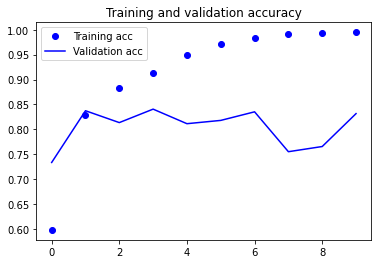

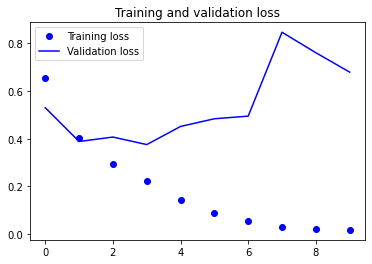

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 데이터를 사용한 첫번재 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝자기 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다. (약 85%의 검증 정확도). 

* 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 
* 다른 이유는 SimpleRNN이 텍스트처럼 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 

더 잘 작동하는 다른 순환층이 있습니다.

### LSTM과 GRU 층 이해하기

`SimpleRNN`외에도 다른 순환 층이 있습니다.
* LSTM
* GRU

SimpleRNN은 실전에서 쓰기에 너무 단순합니다. 이론적으로 시간 t에서 이전의 모든 타임스텝의 정보를 유지할 수 있습니다. 하지만 실제로는 긴 시간에 걸친 의존성은 학습할 수 없는 것이 문제입니다. 층이 많은 Feedforward Network에서 나타나는 것과 비슷한 현상인 **그래디언트 손실 현상 (Vanishing Gradient Problem)**때문입니다.

* 역전파가 진행되는 동안 타임스텝마다 동일한 가중치를 사용하기 때문에 타임스텝이 길어질수록 그래디언트 값이 급격히 줄어들거나 급격히 증가할 수 있습니다.
* 이 문제를 해결하기 위해 고안된 것이 LSTM과 GRU입니다.

LSTM (Long short-term memory)
* 정보를 여러 타임스텝에 걸쳐 나르는 방법이 추가됨
* 나중을 위해 정보를 저장함으로써 처리 과정에서 오래된 시그널이 점차 소실되는 것을 막아줌

<br></br>
![](../images/6-2-lstm1.png)
<br></br>

SimpleRNN의 Cell입니다. 
* 가중치의 행렬 여러개가 나오므로 출력을 나타내는 문자 o로 셀에 있는 W와 U 행렬을 표현합니다 (Wo와 Uo)

이 Cell에 타임스텝을 가로질러 정보를 나르는 데이터 흐름을 추가해봅시다.
* 타임스텝 t에서 이 값을 이동 상태 c_t라고 부르겠습니다
* 이 정보를 사용하여 셀이 다음과 같이 바뀝니다.
* 입력 연결과 순환 연결 (state)로 부터 이 정보가 합성됩니다.
* 가중치 행렬과 점곱한 후 편향을 더하고 활성화 함수를 적용합니다
* 다음 타임스텝으로 전달될 상태로 변경시킵니다 (활성화 함수와 곱셈을 통하여)

<br></br>
![](../images/6-2-lstm2.png)
<br></br>

복잡한 부분은 데이터 흐름에서 다음 이동 상태 ($c_{t+1}$)가 계산되는 방식입니다.
* 3개의 다른 변환이 관련되어 있습니다.
* 3개 모두 SimpleRNN과 같은 형태를 가집니다
* `y = activation(dot(state_t, U) + dot(input_t, W) + b)`
* 3개의 변환 모두 자신만의 가중치 행렬을 가집니다 (i, f, k)

```python
output_t = activation(c_t) * activation(dot(input_t, W_o) + dot(state_t, U_o) + b_o)

i_t = activation(dot(state_t, U_i) + dot(input_t, W_i) + b_i)
f_t = activation(dot(state_t, U_f) + dot(input_t, W_f) + b_f)
k_t = activation(dot(state_t, U_k) + dot(input_t, W_k) + b_k)
```

i_t, f_t, k_t를 결합하여 새로운 이동 상태 ($c_{t+1}$)를 구합니다

```python
c_t+1 = i_t * k_t + c_t * f_t
```

<br></br>
![](../images/6-2-lstm3.png)
<br></br>

복잡해보이지만 연산이 하는 일을 해석하면 각 의미에 대한 통찰을 얻을 수 있습니다.
* c_t과 f_t의 곱셈은 이동을 위한 데이터 흐름에서 관련이 적은 정보를 의도적으로 삭제한다고 볼 수 있습니다
* i_t와 k_t는 현재에 대한 정보를 제동하고 이동 트랙을 새로운 정보로 업데이트합니다
* 이런 해석때문에 f_t의 계산식을 **forget gate (삭제 게이트)**
* i_t의 계산식을 **input gate (인풋 게이트)**라고 부릅니다
* 가중치는 엔드-투-엔드 방식으로 학습됩니다
* 이 과정은 훈련 반복마다 매번 새로 시작되며 연산들에 특정 목적을 부여하기가 힘듭니다
* RNN의 사양 (**specification**)은 가설 공간을 결정합니다
* 셀의 사양은 셀이 하는 일을 결정하지 않습니다.
* 셀의 가중치에 달려있습니다
* 같은 셀이더라도 다른 가중치를 가지는 경우 매운 다른 작업을 수행합니다

### 케라스를 사용한 LSTM 예제

##### 케라스에서 LSTM 층 사용하기

In [12]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.7663

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20000/20000 [==============================] - 23s 1ms/sample - loss: 0.5150 - accuracy: 0.7663 - val_loss: 0.6246 - val_accuracy: 0.7440
Epoch 2/10
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.3042 - accuracy: 0.8841 - val_loss: 0.2957 - val_accuracy: 0.8814
Epoch 3/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.2377 - accuracy: 0.9117 - val_loss: 0.3987 - val_accuracy: 0.8170
Epoch 4/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.2013 - accuracy: 0.9263 - val_loss: 0.3818 - val_accuracy: 0.8750
Epoch 5/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.1792 - accuracy: 0.9348 - val_loss: 0.3631 - val_accuracy: 0.8798
Epoch 6/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.1593 - accuracy: 0.9434 - val_loss: 0.3416 - val_accuracy: 0.8530
Epoch 7/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.1469 - accuracy: 0.9487 - val_loss

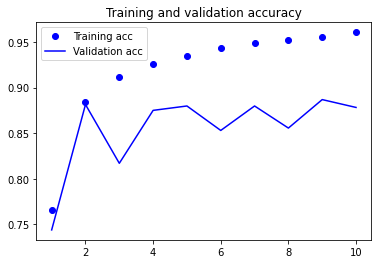

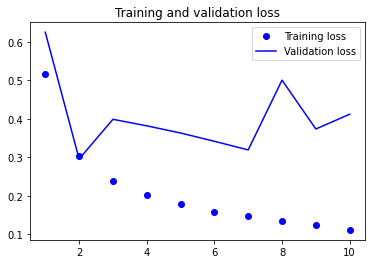

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이번에는 88%의 검증 정확도를 달성했습니다. LSTM이 그래디언트 소실 문제로부터 덜 영향을 받기 때문입니다.